In [1]:
import numpy as np 
import pandas as pd 
import re

In [4]:
import numpy as np
import pandas as pd
import re
import json

class WordPieceTokenizer:
    
    """
    Initialisation: 
    1. Create a dictionary to store vocab and another to store freq
    2. Define vocab size
    """
    def __init__(self, vocab_size : int):
        
        self.vocab = []
        self.word_freq = {}
        self.vocab_size = vocab_size
    
    """
    Preprocessing: 
    1. Convert to lower case
    2. Split into words & remove spaces
    3. Remove numbers & non-alphabetic chars like ",", ".", "!" etc. 
    4. Returns an array of strings
    """
    def preprocess_data(self, text: str):
        
        text = text.lower() 
        text = re.sub(r"[^a-zA-Z\s]", "", text) #replacing characters using RegEx
        return text.split()
    
    """
    Vocab Construction: 
    1. Preprocess the data and store in dict the frequency of every word/token
    2. Create alphabets from the  by splitting each word into letters
    3. Create splits for every word i.e. storing letters of each word in a dictionary
    4. 
    """
    def construct_vocabulary(self, corpus: list):
        
        # we get corpus as a list of sentences
        # preprocess the list and store word frequencies
        for sentence in corpus:
            tokens = self.preprocess_data(sentence)
            
            for token in tokens:
                self.word_freq[token] = self.word_freq.get(token, 0) + 1
                
        # create an initial vocabulary and splits for every word
        initial_vocabulary = [] #unique morphemes stored
        splits = {}
        for word in self.word_freq.keys():
            if word[0] not in initial_vocabulary:
                initial_vocabulary.append(word[0])
            splits[word] = []
            splits[word].append(word[0])
            
            for remaining_letter in word[1:]:
                if f"##{remaining_letter}" not in initial_vocabulary:
                    initial_vocabulary.append(f"##{remaining_letter}")
                splits[word].append(f"##{remaining_letter}")
            
        initial_vocabulary.sort()
        
        self.vocab = ["[PAD]", "[UNK]"] + initial_vocabulary.copy() # adding two special tokens to vocab
        
        # compute scores for pairs
        # merge pair
        # continue until desired vocab size is reached
        while len(self.vocab) < self.vocab_size:
            
            # calculate the scores for every possible pair in a given words' split
            scores = self.compute_all_pair_scores(splits) # returns a dictionary => pair (tuple) : score (float)
            best_pair, max_score = (), -1
            for pair, score in scores.items():
                if max_score == -1 or max_score < score:
                    best_pair = pair
                    max_score = score
             
            # merge the best pair selected in all the splits and add the merged pair to vocab   
            splits = self.merge_best_pair(best_pair[0], best_pair[1], splits)
            
            merged_pair = ""
            if best_pair[1].startswith("##") :
                merged_pair = best_pair[0] + best_pair[1][2:]
            else :
                merged_pair = best_pair[0] + best_pair[1]
                
            self.vocab.append(merged_pair)
        
        self.save_vocabulary()
            
    """
        Tokenization Process:  
        1. We preprocess the input text to clean and normalize it.  
        2. We tokenize each word into subword units using the `subword_tokenise` method.  
        3. We flatten the list of subword tokens to get a single sequence.  
        4. Finally, we return the complete list of subword tokens.  
    """
    def tokenize(self, text: str):
        processed_text = self.preprocess_data(text) 
        
        subword_tokens = []  
        for word in processed_text:  
            subword_tokens.append(self.subword_tokenise(word))  
            
        flattened_tokens = []
        for tokens in subword_tokens:
            flattened_tokens.extend(tokens)   
            
        return flattened_tokens

    
    
   ####----------------------##____________Helper Methods____________##----------------------####
    
    def save_vocabulary(self):
        vocab_file = f"vocabulary_86.txt"
        with open(vocab_file, "w") as f:
            for token in self.vocab:
                f.write(f"{token}\n")
    
    
    """
    Pair Score Computation:  
    1. We count the frequency of individual tokens and adjacent token pairs from word splits.  
    2. Then store token frequencies in `letter_freq_dict` and pair frequencies in `pair_freq_dict`.  
    3. Compute the score for each token pair using their frequency and individual token frequencies.  
    4. Return the computed scores for determining merge priorities in tokenization.  
    """
    def compute_all_pair_scores(self, splits):
        letter_freq_dict = {}
        pair_freq_dict = {}
        
        #cnt the occurrences
        for word, cnt in self.word_freq.items():
            
            split = splits[word]
            for token in split:
                letter_freq_dict[token] = letter_freq_dict.get(token, 0) + cnt
            
            if len(split) == 1 :
                continue
            else: 
                for i in range(len(split)-1):
                    pair = (split[i], split[i+1]) 
                    pair_freq_dict[pair] = pair_freq_dict.get(pair, 0) + cnt
                    
        scores = {}
        #calc the score
        for pair, freq in pair_freq_dict.items(): 
            score = freq / (letter_freq_dict[pair[0]] * letter_freq_dict[pair[1]])
            scores[pair] = score
                
        return scores
    
    
    """
    Best Pair Merging:  
    1. We iterate over each word and look for occurrences of the given token pair (a, b).  
    2. If we find the pair, we merge it into a single token and update the word’s split.  
    3. We ensure the updated split is stored back, allowing further merges if needed.  
    4. Finally, we return the modified splits with the merged tokens.  
    """
    def merge_best_pair(self, x, y, splits):
        for word in self.word_freq:
            split = splits[word]
            i = 0
            # continue until we've checked all adjacent pairs in the split.
            while i < len(split) - 1:
                if split[i] == x and split[i + 1] == y: 
                    if y.startswith("##"):
                        merge = x + y[2:]
                    else:
                        merge = x + y
                    split = split[:i] + [merge] + split[i + 2:]
                    
                    # update the split back in the dictionary.
                    splits[word] = split
                    # do not increment i, in case the new merged token can merge further.
                    # break
                else:
                    i += 1 
                    
            splits[word] = split

        return splits


    """
    Subword Tokenization:  
    1. We iteratively extract the longest valid prefix from the word that exists in our vocabulary.  
    2. If no valid prefix is found, we return the "[UNK]" token.  
    3. We append the matched prefix to the token list and remove it from the word.  
    4. If any part of the word remains, we prepend "##" to indicate it’s a subword and continue.  
    """
    def subword_tokenise(self, word):
        tokens = [] 
        # keep going until word is not empty
        while word:
            prefix = None 
            for i in range(len(word), 0, -1):
                checkWord = word[:i]
                if checkWord in self.vocab:
                    prefix = checkWord
                    break  # found longest valid prefix
            
            # no valid prefix is found -> return the unk token
            if prefix is None:
                return ["[UNK]"]
            else:
                tokens.append(prefix)
            
            # Remove the matched prefix from the word
            word = word[len(prefix):]
            if word:
                word = f"##{word}"
        
        return tokens

####----------------------####----------------------####----------------------####----------------------####----------------------####

def make_vocab_and_tokenize(vocab_size):
    corpus = []
    with open("corpus.txt", 'r') as file: 
        text = file.read()
        sentences = text.split('\n')
        for sentence in sentences: 
            sentence = sentence.strip()
            if sentence:
                corpus.append(sentence)

    # print(corpus)
    tokenizer = WordPieceTokenizer(vocab_size)

    tokenizer.construct_vocabulary(corpus)
    vocab = tokenizer.vocab 

    input_json_path = 'sample_test.json'  
    output_json_path = 'tokenized_86.json' 

    tokenized_data = {}
    with open("corpus.txt", 'r') as file: 
        text = file.read()
        sentences = text.split('\n')
        sentence_id = 0
        for sentence in sentences: 
            sentence = sentence.strip() 
            if sentence:
                tokens = tokenizer.tokenize(sentence)
                tokenized_data[sentence_id] = tokens
                sentence_id += 1

    # Write the tokenized data to the output JSON file
    with open(output_json_path, 'w') as f:
        json.dump(tokenized_data, f, indent=4)

if __name__ == "__main__":
    corpus = []
    with open("corpus.txt", 'r') as file:
        text = file.read()
        sentences = text.split()
        for sentence in sentences:
            sentence = sentence.strip()
            if sentence:
                corpus.append(sentence)

    tokenizer = WordPieceTokenizer(vocab_size=5000)

    tokenizer.construct_vocabulary(corpus)
    vocab = tokenizer.vocab

    output_json_path = 'tokenized_data.json'  # Path to save tokenized output

    # Prepare a dictionary to store the tokenized sentences
    tokenized_data = {}
    with open("corpus.txt", 'r') as file:
        text = file.read()
        sentences = text.split('\n')
        sentence_id = 0
        for sentence in sentences:
            sentence = sentence.strip()
            if sentence:
                tokens = tokenizer.tokenize(sentence)
                tokenized_data[sentence_id] = tokens
                sentence_id += 1

    # Write the tokenized data to the output JSON file
    with open(output_json_path, 'w') as f:
        json.dump(tokenized_data, f, indent=4)

Loaded Data
Training...


  0%|          | 0/40 [00:00<?, ?it/s]

Epoch 1, Loss: 6.316327382059931


  2%|▎         | 1/40 [00:18<12:15, 18.85s/it]

Epoch 2, Loss: 4.052131294046791


  5%|▌         | 2/40 [00:40<12:55, 20.40s/it]

Epoch 3, Loss: 3.93645353224671


  8%|▊         | 3/40 [01:24<19:16, 31.26s/it]

Epoch 4, Loss: 3.7883928585978386


 10%|█         | 4/40 [01:40<15:06, 25.17s/it]

Epoch 5, Loss: 3.6441547916930856


 12%|█▎        | 5/40 [01:54<12:23, 21.24s/it]

Epoch 6, Loss: 3.5284558198984386


 15%|█▌        | 6/40 [02:07<10:29, 18.52s/it]

Epoch 7, Loss: 3.434492821832305


 18%|█▊        | 7/40 [02:21<09:15, 16.85s/it]

Epoch 8, Loss: 3.3537086792362545


 20%|██        | 8/40 [02:34<08:23, 15.75s/it]

Epoch 9, Loss: 3.2851079991720256


 22%|██▎       | 9/40 [02:57<09:18, 18.02s/it]

Epoch 10, Loss: 3.227698483513397


 25%|██▌       | 10/40 [03:26<10:38, 21.30s/it]

Epoch 11, Loss: 3.1793121689731634


 28%|██▊       | 11/40 [03:40<09:10, 18.99s/it]

Epoch 12, Loss: 3.136616632776353


 30%|███       | 12/40 [03:52<07:58, 17.07s/it]

Epoch 13, Loss: 3.097611485175716


 32%|███▎      | 13/40 [04:03<06:49, 15.15s/it]

Epoch 14, Loss: 3.0618678180916796


 35%|███▌      | 14/40 [04:15<06:09, 14.22s/it]

Epoch 15, Loss: 3.0284838838484682


 38%|███▊      | 15/40 [04:27<05:41, 13.66s/it]

Epoch 16, Loss: 2.997419445260057


 40%|████      | 16/40 [04:39<05:15, 13.16s/it]

Epoch 17, Loss: 2.970225709155925


 42%|████▎     | 17/40 [04:52<04:58, 12.97s/it]

Epoch 18, Loss: 2.9444357770160563


 45%|████▌     | 18/40 [05:06<04:53, 13.33s/it]

Epoch 19, Loss: 2.9207361600931407


 48%|████▊     | 19/40 [05:19<04:36, 13.18s/it]

Epoch 20, Loss: 2.8983877260708115


 50%|█████     | 20/40 [05:33<04:30, 13.50s/it]

Epoch 21, Loss: 2.87636434453205


 52%|█████▎    | 21/40 [06:05<06:01, 19.03s/it]

Epoch 22, Loss: 2.8563325613447765


 55%|█████▌    | 22/40 [06:27<05:56, 19.80s/it]

Epoch 23, Loss: 2.8359429072407845


 57%|█████▊    | 23/40 [06:46<05:33, 19.63s/it]

Epoch 24, Loss: 2.818293934886895


 60%|██████    | 24/40 [07:11<05:42, 21.40s/it]

Epoch 25, Loss: 2.800692280519356


 62%|██████▎   | 25/40 [07:38<05:42, 22.86s/it]

Epoch 26, Loss: 2.783492967920396


 65%|██████▌   | 26/40 [08:13<06:11, 26.57s/it]

Epoch 27, Loss: 2.7671617628301233


 68%|██████▊   | 27/40 [08:27<04:55, 22.75s/it]

Epoch 28, Loss: 2.752238838418016


 70%|███████   | 28/40 [08:47<04:22, 21.89s/it]

Epoch 29, Loss: 2.7372297129584746


 72%|███████▎  | 29/40 [09:01<03:37, 19.76s/it]

Epoch 30, Loss: 2.72395169850692


 75%|███████▌  | 30/40 [09:15<03:00, 18.00s/it]

Epoch 31, Loss: 2.709398519645617


 78%|███████▊  | 31/40 [09:29<02:29, 16.62s/it]

Epoch 32, Loss: 2.6964207112210468


 80%|████████  | 32/40 [09:43<02:07, 15.92s/it]

Epoch 33, Loss: 2.6844567349813517


 82%|████████▎ | 33/40 [09:57<01:46, 15.27s/it]

Epoch 34, Loss: 2.672094706192757


 85%|████████▌ | 34/40 [10:17<01:40, 16.73s/it]

Epoch 35, Loss: 2.6594082059212103


 88%|████████▊ | 35/40 [10:31<01:19, 15.89s/it]

Epoch 36, Loss: 2.6492468639484885


 90%|█████████ | 36/40 [10:45<01:00, 15.21s/it]

Epoch 37, Loss: 2.638957856928261


 92%|█████████▎| 37/40 [11:00<00:45, 15.21s/it]

Epoch 38, Loss: 2.6300285927300315


 95%|█████████▌| 38/40 [11:14<00:29, 14.90s/it]

Epoch 39, Loss: 2.619536890566928


 98%|█████████▊| 39/40 [11:27<00:14, 14.40s/it]

Epoch 40, Loss: 2.6094656268369802


100%|██████████| 40/40 [11:40<00:00, 17.50s/it]


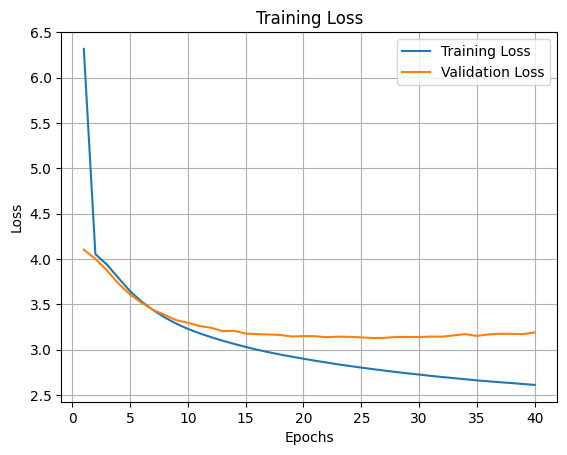

Word: [PAD]
Similar: [('doom', np.float32(0.5208)), ('but', np.float32(0.506)), ('surround', np.float32(0.4992))]
Dissimilar: ('conclusion', np.float32(-0.4128))

Word: [UNK]
Similar: [('unti', np.float32(0.1769)), ('##sory', np.float32(0.1739)), ('difficul', np.float32(0.1656))]
Dissimilar: ('disillus', np.float32(-0.1635))

Word: ##a
Similar: [('##vious', np.float32(0.5842)), ('warmth', np.float32(0.5819)), ('limits', np.float32(0.5441))]
Dissimilar: ('bungalow', np.float32(-0.526))

Word: ##b
Similar: [('unpl', np.float32(0.5454)), ('thack', np.float32(0.5402)), ('taiwan', np.float32(0.5287))]
Dissimilar: ('khalifa', np.float32(-0.3822))

Word: ##c
Similar: [('##haviour', np.float32(0.5932)), ('slumb', np.float32(0.5579)), ('spoil', np.float32(0.539))]
Dissimilar: ('diss', np.float32(-0.2997))

Word: ##d
Similar: [('hanging', np.float32(0.5019)), ('physically', np.float32(0.4792)), ('##ndship', np.float32(0.4746))]
Dissimilar: ('abit', np.float32(-0.2926))

Word: ##e
Similar: [('blu

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.ao.nn.quantized import Dropout
from torch.nn.functional import dropout
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import matplotlib.pyplot as plt
import json
from tqdm import tqdm
import torch.nn.functional
import task1

vocabulary_size = 5000
context_window = 2
embedding_dim = 400
batch_size = 1024
epochs = 40
lr = 0.001
dropout_rate = 0.1
word_index_mapping, index_word_mapping = {}, {}
train_dataloader = []
val_dataloader = []

class Word2VecDataset(Dataset):
    def __init__(self, corpus):
        self.preprocessed_data = []
        self.corpus = corpus

    def __len__(self):
        return len(self.preprocessed_data)

    def __getitem__(self, index):
        target, context = self.preprocessed_data[index]
        context_tensor = torch.tensor(context, dtype=torch.long)

        total_padding = 2 * context_window - len(context_tensor)

        left_padding = total_padding // 2
        right_padding = total_padding - left_padding

        context = torch.nn.functional.pad(context_tensor, (left_padding, right_padding), value=0)
        return torch.tensor(target, dtype=torch.long), context

    def preprocess_data(self, word_index_mapping):
        data = []
        for key in self.corpus:
            tokens = self.corpus[key]

            n = len(tokens)

            for i in range(0, n):
                target = tokens[i]

                # if target not in word_index_mapping:
                #     print(f"Warning: '{target}' not found in vocabulary, skipping.")
                #     continue  # Skip this word

                tokens_before_word = tokens[max(0, i - context_window):i]
                tokens_after_word = tokens[i + 1: min(n + 1, i + 1 + context_window)]

                context = tokens_before_word + tokens_after_word

                target_index = word_index_mapping[target]
                context_index = []
                for word in context:
                    if word in word_index_mapping:
                        context_index.append(word_index_mapping[word])

                if len(context_index) > 0:
                    data.append((target_index, context_index))

        self.preprocessed_data = data


class Word2VecModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.linear = nn.Linear(embedding_dim, vocab_size)

        nn.init.xavier_uniform_(self.embedding.weight)
        nn.init.xavier_uniform_(self.linear.weight)
        if self.linear.bias is not None:
            nn.init.zeros_(self.linear.bias)

    def forward(self, context):
        embedded = self.embedding(context)  # [batch_size, context_length, embedding_dim]
        aggregated = embedded.mean(dim=1)     # [batch_size, embedding_dim]
        aggregated = self.dropout(aggregated)   # Apply dropout
        out = self.linear(aggregated)           # [batch_size, vocab_size]
        return out

    def train_model(self, model, criterion, optimizer):
        loss_list, val_loss = [], []

        for _ in tqdm(range(epochs)):
            total_loss = 0
            model.train()  # enable this if we r able to implement some dropout thingy

            for target, context in train_dataloader:
                target = target.long()
                context = context.long()

                pred = model.forward(context)
                loss = criterion(pred, target)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

                total_loss += loss.item()

            number_of_samples = len(train_dataloader)
            avg_loss = total_loss / number_of_samples
            loss_list.append(avg_loss)
            print(f"Epoch {_ + 1}, Loss: {avg_loss}")

            total_loss = 0
            model.eval()

            with torch.no_grad():
                for target, context in val_dataloader:
                    target = target.long()
                    context = context.long()

                    pred = model.forward(context)
                    loss = criterion(pred, target)
                    total_loss += loss.item()

            avg_val_loss = total_loss / len(val_dataloader)
            val_loss.append(avg_val_loss)

        return loss_list, val_loss

    # def get_triplets(self, model):
    #     embeddings = model.network[0].weight.data.cpu().numpy()
    #     similarities = cosine_similarity(embeddings)
    #     triplets = []
    #
    #     for item in word_index_mapping:
    #         word, index = item[0], item[1]
    #
    #         similar, triplet = [], []
    #         similar_indices = np.argsort(similarities[index])[::-1]
    #         similar_indices = similar_indices[:3]
    #
    #         for i in similar_indices:
    #             similar.append(index_word_mapping[i])
    #         del similar[index_word_mapping[index]]
    #
    #         dissimilar_index = np.argsort(similarities[idx])[0]
    #         dissimilar = index_word_mapping[dissimilar_index]
    #
    #         triplet = [word, similar, dissimilar]
    #         triplets.append(triplet)
    #
    #     for triplet in triplets:
    #         print("Word:", triplet[0])
    #         print("Similar:", triplet[1])
    #         print("Dissimilar:", triplet[2])
    #         print()
    def get_triplets(self):
        embeddings = self.embedding.weight.data.cpu().numpy()
        similarities = cosine_similarity(embeddings)

        triplets = []

        for word, index in word_index_mapping.items():
            similar = []

            similar_indices = np.argsort(similarities[index])[::-1]
            similar_indices = [i for i in similar_indices if i != index][:3]

            for i in similar_indices:
                similar.append((index_word_mapping[i], similarities[index][i]))

            dissimilar_index = np.argsort(similarities[index])[0]
            dissimilar = (index_word_mapping[dissimilar_index], similarities[index][dissimilar_index])

            triplets.append([word, similar, dissimilar])

        for triplet in triplets:
            print("Word:", triplet[0])
            print("Similar:", [(w, round(sim, 4)) for w, sim in triplet[1]])
            print("Dissimilar:", (triplet[2][0], round(triplet[2][1], 4)))
            print()

        return triplets


def get_data(vocab_size, split=0.9):
    task1.make_vocab_and_tokenize(vocab_size)

    file_path = "tokenized_data.json"
    with open(file_path, "r", encoding="utf-8") as file:
        corpus = json.load(file)

    vocab_file_path = "vocabulary_86.txt"

    with open(vocab_file_path, "r", encoding="utf-8") as f:
        vocab = [line.strip() for line in f]

    word_index_mapping = {word: idx for idx, word in enumerate(vocab)}
    index_word_mapping = {idx: word for word, idx in word_index_mapping.items()}
    dataset = Word2VecDataset(corpus)
    dataset.preprocess_data(word_index_mapping)

    n = len(dataset)
    train = int(n * split)
    val = n - train

    train_dataset, val_dataset = random_split(dataset, [train, val])

    train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)

    return train_dataloader, val_dataloader, word_index_mapping, index_word_mapping


def plot(loss_list, val_loss):
    plt.plot(range(1, epochs + 1), loss_list, label="Training Loss")
    plt.plot(range(1, epochs + 1), val_loss, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training Loss")
    plt.savefig("task_2.png")
    plt.legend()
    plt.grid(visible=True)
    plt.show()

def get_triplet_for_word(self, word):
    if word not in word_index_mapping:
        print(f"Word '{word}' not found in vocabulary.")
        return None

    index = word_index_mapping[word]
    embeddings = self.embedding.weight.data.cpu().numpy()
    similarities = cosine_similarity(embeddings)

    # Get sorted indices of words based on similarity (descending order)
    similar_indices = np.argsort(similarities[index])[::-1]

    # Exclude the word itself (index = `index`)
    similar_indices = [i for i in similar_indices if i != index][:3]

    similar_words = [(index_word_mapping[i], similarities[index][i]) for i in similar_indices]

    # Find the most dissimilar word (smallest similarity score)
    dissimilar_index = np.argsort(similarities[index])[0]  # Least similar word
    dissimilar_word = index_word_mapping[dissimilar_index]
    dissimilar_similarity = similarities[index][dissimilar_index]

    # Print results
    print(f"Word: {word}")
    print("Similar Words (with Cosine Similarity):")
    for sim_word, sim_value in similar_words:
        print(f"  {sim_word}: {sim_value:.4f}")

    print(f"Dissimilar Word: {dissimilar_word} (Cosine Similarity: {dissimilar_similarity:.4f})\n")

    return word, similar_words, (dissimilar_word, dissimilar_similarity)

def run_Word2Vec(vocabulary_size_ = 14000, context_window_ = 2,embedding_dim_ = 400,batch_size_ = 1024,epochs_ = 50,lr_ = 0.001, dropout_rate_ = 0.1):

    global train_dataloader, val_dataloader, word_index_mapping, index_word_mapping, vocabulary_size, context_window, embedding_dim, batch_size, epochs, lr, dropout_rate

    vocabulary_size = vocabulary_size_
    context_window = context_window_
    embedding_dim = embedding_dim_
    batch_size = batch_size_
    epochs = epochs_
    lr = lr_
    dropout_rate = dropout_rate_

    train_dataloader, val_dataloader, word_index_mapping, index_word_mapping = get_data(vocabulary_size)

    print("Loaded Data")

    model = Word2VecModel(vocabulary_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-5)

    print("Training...")

    loss_list, val_loss = model.train_model(model, criterion, optimizer)
    plot(loss_list, val_loss)

    torch.save(model.state_dict(), "word2vec_checkpoint.pth")

    model.get_triplets()

    get_triplet_for_word(model, "is")

if __name__ == "__main__":
    run_Word2Vec( vocabulary_size_= vocabulary_size, context_window_= context_window, embedding_dim_= embedding_dim, batch_size_= batch_size, epochs_= epochs, lr_= lr, dropout_rate_=dropout_rate)


In [12]:
# Load vocabulary
vocab_file_path = "vocabulary_86.txt"
with open(vocab_file_path, "r", encoding="utf-8") as f:
    vocab = [line.strip() for line in f]

# Create mappings
word_to_idx = {word: idx for idx, word in enumerate(vocab)}
idx_to_word = {idx: word for word, idx in word_to_idx.items()}

# Hyperparameters
embedding_dim = 400  # This must match Task 2

# Initialize Word2Vec model
word2vec_model = Word2VecModel(len(vocab))
word2vec_model.load_state_dict(torch.load("word2vec_checkpoint.pth"))
word2vec_model.eval()  # Set to evaluation mode


/var/folders/yt/h8g2tq612_99wzrx5yrmx9bm0000gn/T/ipykernel_69508/2263617468.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  word2vec_model.load_state_dict(torch.load("w

Word2VecModel(
  (embedding): Embedding(14000, 400)
  (dropout): Dropout(p=0.3, inplace=False)
  (linear): Linear(in_features=400, out_features=14000, bias=True)
)

In [7]:
class NeuralLMDataset(Dataset):
    def __init__(self, corpus, word_to_idx, context_size=4):
        self.word_to_idx = word_to_idx
        self.context_size = context_size
        self.data = self.preprocess_data(corpus)

    def preprocess_data(self, corpus):
        data = []
        for key in corpus:
            tokens = corpus[key]  # Tokenized sentence from tokenized_data.json
            for i in range(len(tokens) - self.context_size):
                context = tokens[i:i + self.context_size]
                target = tokens[i + self.context_size]
                if all(word in self.word_to_idx for word in context + [target]):  # Ensure all words exist in vocab
                    context_indices = [self.word_to_idx[word] for word in context]
                    target_index = self.word_to_idx[target]
                    data.append((context_indices, target_index))
        return data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        context, target = self.data[idx]
        return torch.tensor(context, dtype=torch.long), torch.tensor(target, dtype=torch.long)


In [8]:
class NeuralLM1(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size, hidden_dim=128):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.fc1 = nn.Linear(context_size * embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, context):
        embedded = self.embeddings(context).view(context.shape[0], -1)  # Flatten
        hidden = torch.relu(self.fc1(embedded))
        output = self.fc2(hidden)
        return output


class NeuralLM2(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size, hidden_dim=256):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.fc1 = nn.Linear(context_size * embedding_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, vocab_size)
        self.dropout = nn.Dropout(0.3)  # Dropout for regularization

    def forward(self, context):
        embedded = self.embeddings(context).view(context.shape[0], -1)
        hidden = torch.relu(self.fc1(embedded))
        hidden = self.dropout(torch.relu(self.fc2(hidden)))
        output = self.fc3(hidden)
        return output


class NeuralLM3(nn.Module):
    def __init__(self, vocab_size, embedding_dim, context_size, hidden_dim=512):
        super().__init__()
        self.embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.fc1 = nn.Linear(context_size * embedding_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)  # BatchNorm Layer
        self.fc2 = nn.Linear(hidden_dim, vocab_size)

    def forward(self, context):
        embedded = self.embeddings(context).view(context.shape[0], -1)
        hidden = torch.relu(self.bn1(self.fc1(embedded)))  # Apply BatchNorm
        output = self.fc2(hidden)
        return output

In [9]:
def train_neural_lm(model, dataloader, criterion, optimizer, epochs=10):
    model.train()
    losses = []

    for epoch in range(epochs):
        total_loss = 0
        for context, target in dataloader:
            context, target = context.long(), target.long()

            optimizer.zero_grad()
            output = model(context)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()

        avg_loss = total_loss / len(dataloader)
        losses.append(avg_loss)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {avg_loss:.4f}")

    return losses

Training NeuralLM1...
Epoch [1/45], Loss: 7.5773
Epoch [2/45], Loss: 5.8539
Epoch [3/45], Loss: 5.4077
Epoch [4/45], Loss: 5.0415
Epoch [5/45], Loss: 4.6461
Epoch [6/45], Loss: 4.2185
Epoch [7/45], Loss: 3.7691
Epoch [8/45], Loss: 3.4033
Epoch [9/45], Loss: 3.1547
Epoch [10/45], Loss: 2.9829
Epoch [11/45], Loss: 2.8454
Epoch [12/45], Loss: 2.7090
Epoch [13/45], Loss: 2.5977
Epoch [14/45], Loss: 2.5126
Epoch [15/45], Loss: 2.4112
Epoch [16/45], Loss: 2.3363
Epoch [17/45], Loss: 2.2549
Epoch [18/45], Loss: 2.1923
Epoch [19/45], Loss: 2.1279
Epoch [20/45], Loss: 2.0717
Epoch [21/45], Loss: 2.0065
Epoch [22/45], Loss: 1.9555
Epoch [23/45], Loss: 1.8917
Epoch [24/45], Loss: 1.8371
Epoch [25/45], Loss: 1.7902
Epoch [26/45], Loss: 1.7475
Epoch [27/45], Loss: 1.7043
Epoch [28/45], Loss: 1.6552
Epoch [29/45], Loss: 1.6147
Epoch [30/45], Loss: 1.5807
Epoch [31/45], Loss: 1.5416
Epoch [32/45], Loss: 1.4998
Epoch [33/45], Loss: 1.4612
Epoch [34/45], Loss: 1.4283
Epoch [35/45], Loss: 1.3917
Epoch [

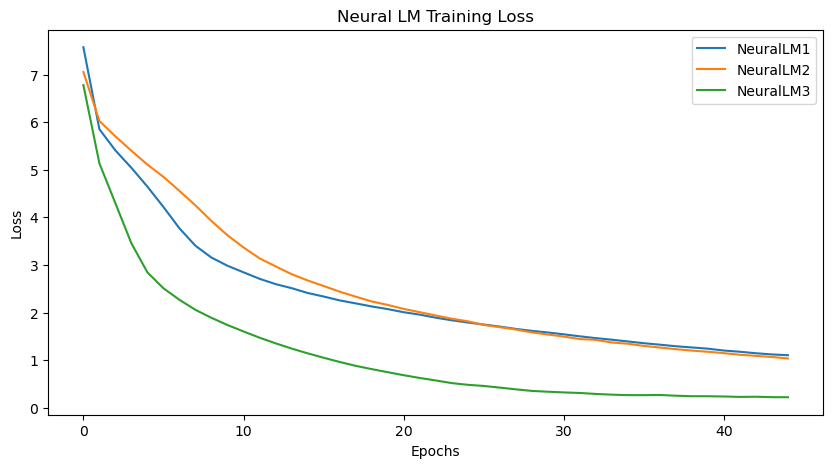

In [11]:
# Load tokenized data
with open("tokenized_data.json", "r", encoding="utf-8") as f:
    corpus = json.load(f)

# Hyperparameters
context_size = 4
embedding_dim = 50
batch_size = 1024
epochs = 45
learning_rate = 0.002

# Create dataset and dataloader
dataset = NeuralLMDataset(corpus, word_to_idx, context_size)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Initialize models
models = {
    "NeuralLM1": NeuralLM1(len(vocab), embedding_dim, context_size),
    "NeuralLM2": NeuralLM2(len(vocab), embedding_dim, context_size),
    "NeuralLM3": NeuralLM3(len(vocab), embedding_dim, context_size),
}

# Train all models and plot loss curves
plt.figure(figsize=(10, 5))
for name, model in models.items():
    print(f"Training {name}...")
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.CrossEntropyLoss()
    losses = train_neural_lm(model, dataloader, criterion, optimizer, epochs)

    # Plot losses
    plt.plot(losses, label=name)

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Neural LM Training Loss")
plt.legend()
plt.show()

In [13]:
def compute_accuracy(model, dataloader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for context, target in dataloader:
            context, target = context.long(), target.long()
            output = model(context)
            predicted = torch.argmax(output, dim=1)  # Get index of highest probability
            correct += (predicted == target).sum().item()
            total += target.size(0)

    accuracy = correct / total
    return accuracy

import math

def compute_perplexity(model, dataloader, criterion):
    model.eval()
    total_loss = 0
    total_samples = 0

    with torch.no_grad():
        for context, target in dataloader:
            context, target = context.long(), target.long()
            output = model(context)
            loss = criterion(output, target)
            total_loss += loss.item() * target.size(0)  # Multiply by batch size
            total_samples += target.size(0)

    avg_loss = total_loss / total_samples
    perplexity = math.exp(avg_loss)
    return perplexity

In [ ]:
criterion = nn.CrossEntropyLoss()

for name, model in models.items():
    print(f"Evaluating {name}...")

    acc = compute_accuracy(model, dataloader)
    ppl = compute_perplexity(model, dataloader, criterion)

    print(f"{name} - Accuracy: {acc * 100:.2f}% | Perplexity: {ppl:.2f}")

Evaluating NeuralLM1...
NeuralLM1 - Accuracy: 76.07% | Perplexity: 2.71
Evaluating NeuralLM2...
NeuralLM2 - Accuracy: 87.37% | Perplexity: 1.66
Evaluating NeuralLM3...
NeuralLM3 - Accuracy: 95.71% | Perplexity: 1.17


In [15]:
def predict_next_tokens(model, sentence, word_to_idx, idx_to_word, context_size=4, top_k=1):
    model.eval()
    tokens = sentence.strip().split()  # Simple tokenization (split by space)

    # Ensure the sentence has at least 'context_size' words
    if len(tokens) < context_size:
        print(f"Skipping: '{sentence}' (not enough context words)")
        return []

    # Get the last 'context_size' tokens
    context = tokens[-context_size:]
    
    predicted_words = []
    
    for _ in range(3):  # Predict three tokens
        if all(word in word_to_idx for word in context):
            context_indices = torch.tensor([word_to_idx[word] for word in context], dtype=torch.long).unsqueeze(0)
            output = model(context_indices)  # Get predictions
            
            # Select the top prediction
            predicted_idx = torch.argmax(output, dim=1).item()
            predicted_word = idx_to_word[predicted_idx]

            predicted_words.append(predicted_word)
            context.append(predicted_word)  # Update context with predicted word
            context.pop(0)  # Maintain context size
        else:
            print(f"Unknown words encountered in: '{sentence}'")
            break

    return predicted_words

In [49]:
# Load test sentences
test_file = "sample_test.txt"
with open(test_file, "r", encoding="utf-8") as f:
    test_sentences = [line.strip() for line in f]

# Select a trained model (e.g., NeuralLM3 as it's the best-performing one)
best_model = models["NeuralLM1"]

# Make predictions for each sentence
predictions = {}
for sentence in test_sentences:
    predictions[sentence] = predict_next_tokens(best_model, sentence, word_to_idx, idx_to_word)

# Print results
for sentence, predicted in predictions.items():
    print(f"Input: {sentence}")
    print(f"Predicted: {' '.join(predicted)}\n")


Input: \i felt like earlier this year i was starting to feel emotional that it
Predicted: was a good

Input: i do need constant reminders when i go through lulls in feeling submiss
Predicted: and come away

Input: i was really feeling crappy even after my awesome
Predicted: week from all

Input: i finally realise the feeling of being hated and its after effects are
Predicted: so big amazing

Input: i am trying to
Predicted: make small steps

